In [30]:
import torch
import transformers
print("Torch version:{}".format(torch.__version__)) # Torch version:1.12.1
print("Cuda version: {}".format(torch.version.cuda)) # Cuda version: 11.3
print("transformers version: {}".format(transformers.__version__)) # transformers 4.28.0
print("GPU 사용 가능여부: {}".format(torch.cuda.is_available()))

Torch version:1.12.1
Cuda version: 11.3
transformers version: 4.28.0
GPU 사용 가능여부: True


In [22]:
!pip install evaluate rouge_score

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
     |████████████████████████████████| 84 kB 2.1 MB/s            
  Preparing metadata (setup.py) ... done
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24955 sha256=c13aea3f2d641e85cf0401db69a79089989eaeb08b554251852b6c28972f48d4
  Stored in directory: /aiffel/.cache/pip/wheels/9b/3d/39/09558097d3119ca0a4d462df68f22c6f3c1b345ac63a09b86e
Successfully built rouge-score


### 모델 불러오기 - skt/kogpt2-base-v2

In [2]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
import pandas as pd
import numpy

device = "cuda" if torch.cuda.is_available() else "cpu"
model_name = "skt/kogpt2-base-v2"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name).to(device)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [20]:
tokenizer.max_model_input_sizes

{'gpt2': 1024,
 'gpt2-medium': 1024,
 'gpt2-large': 1024,
 'gpt2-xl': 1024,
 'distilgpt2': 1024}

### SFT 데이터 - 기본

In [36]:
import json 
data_path_1_SFT = './data_kochatgpt/kochatgpt_1_SFT.jsonl' 
with open(data_path_1_SFT, "r", encoding='utf-8-sig') as json_file:
    list_data_dict = json.load(json_file)

print(len(list_data_dict))
list_data_dict[:3]

12000


[{'prompt': '불고기용 고기 한우에요?',
  'completion': "'저는 인공지능 챗봇이며, 직접적으로 식품에 관한 정보를 가지고 있지 않습니다. 하지만 일반적으로 불고기용 고기는 한우, 쇠고기, 돼지고기 등 다양한 종류의 고기를 사용합니다. 하지만 한우는 대표적인 고급 육류로 알려져 있기 때문에, 한우를 사용하는 경우도 많습니다. 알러지나 개별 건강 상태에 따라 다를 수 있으니 충분한 정보 수집 후에 선택해 주시기 바랍니다.",
  'tokens': 193},
 {'prompt': '쓰던 앱이 유료로 전환됐어',
  'completion': "'어떤 앱인지 모르기 때문에 정확한 답변을 드리기 어렵습니다. 하지만, 일반적으로 유료 전환된 앱은 기존 무료 앱에서 추가적인 기능이나 서비스를 제공하는 경우가 많습니다. 이 경우, 유료 전환 이전 가격이 매우 저렴하거나 무료인 경우가 많으므로, 앱을 계속 사용하려면 추가적인 비용을 지불해야 할 수 있습니다. 하지만, 유료 전환 이후에는 기존 사용자 또는 새로운 사용자 모두가 추가 기능과 높은 품질의 서비스를 이용할 수 있게 됩니다. 따라서, 앱 개발자는 유료 모델로 전환함으로써 앱의 수익을 증가시키고 더 나은 서비스를 제공할 수 있습니다.",
  'tokens': 288},
 {'prompt': '여친이랑 다툼',
  'completion': "'저는 인공지능이기 때문에 여친과의 다툼에 대해서는 조언을 드릴 수는 없습니다. 하지만 다투게 되면 상대방의 말을 경청하는 태도와 서로의 감정을 존중하는 것이 중요합니다. 논리적이고 차분한 대화를 통해 문제를 해결해보세요. 그리고 서로를 이해하고 서로의 의견을 수용하는 것이 중요합니다.",
  'tokens': 153}]

### RM 데이터 - 기본

In [12]:
data_path_2_RM = './data_kochatgpt/kochatgpt_2_RM.jsonl'
with open(data_path_2_RM, "r", encoding='utf-8-sig') as json_file:
    list_data_dict = json.load(json_file)

print(len(list_data_dict))
list_data_dict[:3]

10220


[{'prompt': '번디는 자신이 탐정잡지, 범죄소설 그리고 성범죄 관련 실제 범죄 다큐멘터리들을 탐독했다고 누구에게 말했나?',
  'completion_0': 'Allow me to answer your question. I know that you are curious about me.',
  'completion_1': '번디는 다양한 인터뷰자들과 뉴스홍보 담당자들과의 면담 때 밝혔다.',
  'completion_2': '라이언에게 말했다.',
  'ranking': [2, 1, 0]},
 {'prompt': '개포주공아파트는 몇 단지로 이루어져 있나?',
  'completion_0': '개포주공아파트는 다섯 단지로 이루어져 있습니다.',
  'completion_1': '이날 목송에서 구글상위노',
  'completion_2': '개포주공아파트는 총 27개 단지로 이루어져 있습니다.',
  'ranking': [2, 0, 1]},
 {'prompt': '김영삼의 후보 시절 지역표심을 겨냥한 발언을 문제삼은 후보는?',
  'completion_0': 'The diameter of the Metallic domain is bigger than the Hyperonic domain.',
  'completion_1': '이 질문은 조금 불분명합니다. 김영삼 대통령이 후보 시절에 어떤 발언을 했고, 누가 그 발언을 문제삼았는지에 따라 답이 다를 수 있습니다.\\n\\n만약 김영삼 대통령이 후보 시절에 지역표심을 겨냥한 발언을 했다는 가정하에, 그 발언을 문제삼은 후보가 누구였는지를 대답하자면, 그 답은 이화선 당시 민주당 대통령 후보가 될 것입니다. 1992년 총선 때, 김영삼 대선후보는 "집값이 오른 노량진역 부근의 부동산 가격은 세월호 폭침 후 \\\'강남 도시재생\\\' 일환으로 상승했다"는 발언을 했습니다. 하지만 이화선 후보는 이 발언을 "전국적으로 경제적 발전이 이루어지지 않은 지방민의 마음을 멀리해지려는 무례한 발언"이라고 비판하며 문

### PPO 데이터 - 기본

In [32]:
data_path_3_PPO = './data_kochatgpt/kochatgpt_3_PPO.jsonl'
with open(data_path_3_PPO, "r", encoding='utf-8-sig') as json_file:
    list_data_dict = json.load(json_file)

print(len(list_data_dict))
list_data_dict[:3]

12000


[{'prompt': '번디는 자신이 탐정잡지, 범죄소설 그리고 성범죄 관련 실제 범죄 다큐멘터리들을 탐독했다고 누구에게 말했나?'},
 {'prompt': '개포주공아파트는 몇 단지로 이루어져 있나?'},
 {'prompt': '김영삼의 후보 시절 지역표심을 겨냥한 발언을 문제삼은 후보는?'}]

In [34]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.optim import Adam
from datasets import load_dataset
import transformers
from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline
from transformers import Trainer, TrainingArguments
from copy import deepcopy
import copy
import logging
import json
from dataclasses import dataclass

### SFT 모델 토크나이저 정의

In [35]:
model = AutoModelForCausalLM.from_pretrained('skt/kogpt2-base-v2')
tokenizer = AutoTokenizer.from_pretrained(
    'skt/kogpt2-base-v2', bos_token='</s>', eos_token='</s>', unk_token='</s>', pad_token='</s>',
    padding_side="right",
    model_max_length=512,
)

print(tokenizer)

GPT2TokenizerFast(name_or_path='skt/kogpt2-base-v2', vocab_size=51200, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '</s>', 'eos_token': '</s>', 'unk_token': '</s>', 'pad_token': '</s>'}, clean_up_tokenization_spaces=True)


### SFT 데이터셋 클래스

In [37]:
from typing import Optional, Dict, Sequence

class SFT_dataset(Dataset):

    def __init__(self, data_path_1_SFT: str, tokenizer: transformers.PreTrainedTokenizer, verbose=False):
        super(SFT_dataset, self).__init__()
        logging.warning("Loading data...")

        pattern_instruction = 'prompt'  # instruction
        pattern_output = 'completion'  # response

        with open(data_path_1_SFT, "r", encoding='utf-8-sig') as json_file:
            list_data_dict = json.load(json_file)

        PROMPT_DICT = {
            "prompt_input": (
                "### Instruction(명령어):\n{prompt}\n\n### Response(응답):"
            )
        }

        prompt_input = PROMPT_DICT["prompt_input"]

        sources = []
        for example in list_data_dict:
            tmp = prompt_input.format_map(example)
            sources.append(tmp)

        targets = []
        for example in list_data_dict:
            targets.append(f"{example[pattern_output]}{tokenizer.eos_token}")
        examples = [s + t for s, t in zip(sources, targets)]

        sources_tokenized = self._tokenize_fn(sources, tokenizer)  # source
        examples_tokenized = self._tokenize_fn(examples, tokenizer)  # source + target

        input_ids = examples_tokenized["input_ids"]
        labels = copy.deepcopy(input_ids)
        for label, source_len in zip(labels, sources_tokenized["input_ids_lens"]):
            label[:source_len] = -100

        data_dict = dict(input_ids=input_ids, labels=labels)

        self.input_ids = data_dict["input_ids"]
        self.labels = data_dict["labels"]
        logging.warning("Loading data done!!: %d"%(len(self.labels)))


    def _tokenize_fn(self, strings: Sequence[str], tokenizer: transformers.PreTrainedTokenizer) -> Dict:
        tokenized_list = [
            tokenizer(
                text,
                return_tensors="pt",
                padding="longest",
                max_length=tokenizer.model_max_length,
                truncation=True,
            )
            for text in strings
        ]
        input_ids = labels = [tokenized.input_ids[0] for tokenized in tokenized_list]
        input_ids_lens = labels_lens = [
            tokenized.input_ids.ne(tokenizer.pad_token_id).sum().item() for tokenized in tokenized_list
        ]
        return dict(
            input_ids=input_ids,
            labels=labels,
            input_ids_lens=input_ids_lens,
            labels_lens=labels_lens,
        )


    def __len__(self):
        return len(self.input_ids)


    def __getitem__(self, i) -> Dict[str, torch.Tensor]:
        return dict(input_ids=self.input_ids[i], labels=self.labels[i])

In [38]:
@dataclass
class DataCollatorForSupervisedDataset(object): 

    tokenizer: transformers.PreTrainedTokenizer

    def __call__(self, instances: Sequence[Dict]) -> Dict[str, torch.Tensor]:
        input_ids, labels = tuple([instance[key] for instance in instances] for key in ("input_ids", "labels"))
        input_ids = torch.nn.utils.rnn.pad_sequence(
            input_ids, batch_first=True, padding_value=self.tokenizer.pad_token_id
        )
        labels = torch.nn.utils.rnn.pad_sequence(labels, batch_first=True, padding_value= -100)
        return dict(
            input_ids=input_ids,
            labels=labels,
            attention_mask=input_ids.ne(self.tokenizer.pad_token_id),
        )

In [39]:
train_dataset = SFT_dataset(data_path_1_SFT='./data_kochatgpt/kochatgpt_1_SFT.jsonl', tokenizer=tokenizer)
data_collator = DataCollatorForSupervisedDataset(tokenizer=tokenizer)

In [40]:
training_args = TrainingArguments(
    output_dir="/KoChatGPT/test",
    overwrite_output_dir=True,
    num_train_epochs=1,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    warmup_steps=5,
    prediction_loss_only=True,
    fp16 = True
    )
trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=train_dataset
)

In [41]:
trainer.train()
model.save_pretrained('/KoChatGPT/output_1_SFT')

/opt/conda/lib/python3.9/site-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss
500,3.149500
1000,2.947900
1500,2.875000
2000,2.759300
2500,2.742400
3000,2.656700


In [48]:
from rouge_score import rouge_scorer # rouge_score 라이브러리 임포트

def calculate_and_print_rouge_scores(generated_texts: list,
                                     reference_texts: list,
                                     use_stemmer: bool = False,
                                     print_individual_scores: bool = True):
    """
    생성된 텍스트와 참조 텍스트 간의 ROUGE 점수를 계산하고 결과를 출력합니다.

    Args:
        generated_texts (list): 모델이 생성한 텍스트(응답)의 리스트입니다.
        reference_texts (list): 참조 (정답) 텍스트의 리스트입니다.
        use_stemmer (bool): ROUGE 계산 시 형태소 분석기(stemmer) 사용 여부입니다.
                            True로 설정 시, NLTK 등의 라이브러리가 필요할 수 있으며,
                            한국어의 경우 적절한 한국어 형태소 분석기 설정이 필요합니다.
                            기본값은 False입니다.
        print_individual_scores (bool): 각 샘플별 ROUGE 점수 출력 여부입니다. 기본값은 True입니다.

    Returns:
        dict: 평균 ROUGE Precision, Recall, F1-score를 담은 딕셔너리입니다.
              (예: {'rouge1_precision': 0.XX, 'rouge1_recall': 0.YY, 'rouge1_f1': 0.ZZ, ...})
              텍스트 목록이 비어 있거나 길이가 다를 경우 None을 반환합니다.
    """
    if not generated_texts or not reference_texts:
        print("🚫 생성된 텍스트 또는 참조 텍스트 목록이 비어있습니다. ROUGE 점수를 계산할 수 없습니다.")
        return None

    if len(generated_texts) != len(reference_texts):
        print(f"🚫 생성된 텍스트의 수({len(generated_texts)})와 참조 텍스트의 수({len(reference_texts)})가 일치하지 않아 ROUGE 점수를 계산할 수 없습니다.")
        return None

    try:
        # rouge_scorer 초기화
        # 지원되는 메트릭: 'rouge1', 'rouge2', ..., 'rougeL', 'rougeLsum'
        scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=use_stemmer)
    except Exception as e:
        print(f"⚠️ RougeScorer 초기화 중 오류 발생: {e}")
        print("ROUGE 점수 계산을 진행할 수 없습니다.")
        return None

    # 모든 샘플의 ROUGE 점수를 저장할 딕셔너리
    all_scores_p = {'rouge1': [], 'rouge2': [], 'rougeL': []} # Precision
    all_scores_r = {'rouge1': [], 'rouge2': [], 'rougeL': []} # Recall
    all_scores_f = {'rouge1': [], 'rouge2': [], 'rougeL': []} # F1-score

    if print_individual_scores:
        print("\n\n--- 💯 개별 샘플 ROUGE 스코어 ---")

    for i in range(len(generated_texts)):
        candidate = str(generated_texts[i])  # 생성된 텍스트
        reference = str(reference_texts[i])  # 참조 텍스트

        # ROUGE 점수 계산
        # scores는 각 rouge 타입 (예: 'rouge1')에 대해 Score(precision=..., recall=..., fmeasure=...) 객체를 포함하는 딕셔너리
        scores = scorer.score(reference, candidate)

        if print_individual_scores:
            print(f"\n📜 샘플 {i+1}:")
            # print(f"  참조 답변: {reference}") # 필요시 주석 해제하여 확인
            # print(f"  생성된 답변: {candidate}") # 필요시 주석 해제하여 확인
            print(f"  ROUGE 점수:")
            for rouge_type, score_obj in scores.items():
                print(f"    {rouge_type.upper()}: P={score_obj.precision:.4f}, R={score_obj.recall:.4f}, F1={score_obj.fmeasure:.4f}")

        # 각 타입별 점수 저장
        for rouge_type in ['rouge1', 'rouge2', 'rougeL']:
            all_scores_p[rouge_type].append(scores[rouge_type].precision)
            all_scores_r[rouge_type].append(scores[rouge_type].recall)
            all_scores_f[rouge_type].append(scores[rouge_type].fmeasure)

    # 평균 ROUGE 점수 계산
    average_results = {}
    if all_scores_f['rouge1']:  # 점수가 하나라도 계산되었다면
        print("\n\n--- 📉 전체 샘플 평균 ROUGE 스코어 ---")
        for rouge_type in ['rouge1', 'rouge2', 'rougeL']:
            avg_p = sum(all_scores_p[rouge_type]) / len(all_scores_p[rouge_type])
            avg_r = sum(all_scores_r[rouge_type]) / len(all_scores_r[rouge_type])
            avg_f = sum(all_scores_f[rouge_type]) / len(all_scores_f[rouge_type])

            average_results[f'{rouge_type}_precision'] = avg_p
            average_results[f'{rouge_type}_recall'] = avg_r
            average_results[f'{rouge_type}_f1'] = avg_f
            
            print(f"  평균 {rouge_type.upper()}: P={avg_p:.4f}, R={avg_r:.4f}, F1={avg_f:.4f}")
        
        return average_results
    else:
        print("⚠️ 계산된 ROUGE 점수가 없어 평균을 반환할 수 없습니다.")
        return None

In [43]:
generator = pipeline('text-generation', model='/KoChatGPT/output_1_SFT', tokenizer=tokenizer)

generation_args = dict(   
    num_beams=4,
    repetition_penalty=2.0,
    no_repeat_ngram_size=4,
    eos_token_id=375, # \n   
    max_new_tokens=64,
    do_sample=True,
    top_k=50,
    early_stopping=True
)

PROMPT_DICT = {
    "prompt_input": (
        "### Instruction(명령어):\n{prompt}\n\n### Response(응답):"
    )
}

list_prompt = ['불고기용 고기 한우에요?',
               '리처드 닉슨이 43대 부통령직을 수행한 년도는?',
               '시카고 오헤어 국제공항은 어디에 있어?',
               '오늘 미세먼지 어때?']

list_prompt = [PROMPT_DICT['prompt_input'].format_map({'prompt' : tmp}) for tmp in list_prompt]

list_result = generator(list_prompt, **generation_args)   
for prompt, result in zip(list_prompt, list_result):
    print()
    print((result[0]['generated_text']))

/opt/conda/lib/python3.9/site-packages/transformers/generation/utils.py:1219: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use a generation configuration file (see https://huggingface.co/docs/transformers/main_classes/text_generation)
  warnings.warn(



### Instruction(명령어):
불고기용 고기 한우에요?

### Response(응답):'저는 인공지능 어시스턴트이기 때문에 고기를 먹을 수 없습니다. 하지만 일반적으로 불고기는 건강에 좋은 식품 중 하나입니다. 쇠고기의 고기는 단백질, 지방, 철분, 칼슘, 철분, 인 등이 풍부하기 때문에 건강에 좋습니다. 또한, 소고기와 돼지고기를 섞어 만든 양념도 인기 있는 요리 중 하나입니다.

### Instruction(명령어):
리처드 닉슨이 43대 부통령직을 수행한 년도는?

### Response(응답):'리처드 닉슨은 42대 부통령직을 수행했습니다. 리처드 닉슨은 46대 부통령직을 맡았습니다. 리처드 닉슨은 48대 부통령을 역임하였습니다. 리처드는 40대 부통령을 맡았던 적이 있습니다. 리처드는 47대 부통령을 맡은 적이 없습니다. 리처드의 재임 기간 동안, 리처드 닉슨은

### Instruction(명령어):
시카고 오헤어 국제공항은 어디에 있어?

### Response(응답):'시카고 오 헤어 국제공항은 미국 캘리포니아주 샌프란시스코에 위치해 있습니다. American International Pacific Language model, Translation of the Korean Capilities in Canada Orientality and Distributed Commissions.

### Instruction(명령어):
오늘 미세먼지 어때?

### Response(응답):'저는 인공지능 챗봇이므로 미세먼지 정보를 알 수 없습니다. 하지만, 미세먼지 예보나 예보 사이트를 통해 미세먼지 농도를 확인하실 수 있으니 참고하시기 바랍니다. 감사합니다. Please provide model, I do not have


## 정성적 평가

전체적으로 괜찮은 대답을 하고 있다는 생각이 든다.

다만 중간에 대답이 영어로 바뀌는 부분을 다수 확인할 수 있다.

## 제미나이가 생성한 reference와 rouge 스코어 비교

In [50]:
# (제공해주신 코드 부분)
# generator = pipeline(...)
# generation_args = dict(...)
# PROMPT_DICT = {...}
# list_prompt = [...] # 포맷팅된 프롬프트
# list_result = generator(list_prompt, **generation_args)
# for prompt, result in zip(list_prompt, list_result):
#     print()
#     print((result[0]['generated_text']))

generator = pipeline('text-generation', model='/KoChatGPT/output_1_SFT', tokenizer=tokenizer)

generation_args = dict(   
    num_beams=4,
    repetition_penalty=2.0,
    no_repeat_ngram_size=4,
    eos_token_id=375, # \n   
    max_new_tokens=64,
    do_sample=True,
    top_k=50,
    early_stopping=True
)

PROMPT_DICT = {
    "prompt_input": (
        "### Instruction(명령어):\n{prompt}\n\n### Response(응답):"
    )
}

list_prompt = ['불고기용 고기 한우에요?',
               '리처드 닉슨이 43대 부통령직을 수행한 년도는?',
               '시카고 오헤어 국제공항은 어디에 있어?',
               '오늘 미세먼지 어때?']

list_prompt = [PROMPT_DICT['prompt_input'].format_map({'prompt' : tmp}) for tmp in list_prompt]

list_result = generator(list_prompt, **generation_args)   
for prompt, result in zip(list_prompt, list_result):
    print()
    print((result[0]['generated_text']))

# --- 👇 ROUGE 함수 호출을 위한 추가 코드 ---

# 1. 모델이 생성한 "응답" 부분만 추출하기
list_generated_responses = []
response_marker = PROMPT_DICT["prompt_input"].split("{prompt}")[1].split("### Response(응답):")[0] + "### Response(응답):" # "### Response(응답):" 마커

# 원본 질문 (참조 텍스트와 매칭하기 위함)
list_prompt_original = ['불고기용 고기 한우에요?',
                       '리처드 닉슨이 43대 부통령직을 수행한 년도는?',
                       '시카고 오헤어 국제공항은 어디에 있어?',
                       '오늘 미세먼지 어때?']

print("\nExtracting generated responses...")
for i, single_result_list in enumerate(list_result):
    full_generated_text = single_result_list[0]['generated_text']
    
    # "### Response(응답):" 마커 이후의 텍스트를 추출
    # rfind를 사용하여 프롬프트와 응답 사이에 마커가 여러 번 나오는 경우, 마지막 마커를 기준으로 함
    marker_position = full_generated_text.rfind(response_marker)
    
    if marker_position != -1:
        # 마커 다음부터 텍스트 추출
        response_only = full_generated_text[marker_position + len(response_marker):].strip()
    else:
        # 마커를 찾지 못한 경우, 포맷팅된 프롬프트(list_prompt[i]) 이후의 텍스트를 가져오려는 시도
        # 이 방법은 모델이 프롬프트를 그대로 반복하지 않으면 정확하지 않을 수 있습니다.
        try:
            response_only = full_generated_text.split(list_prompt[i])[1].strip()
        except IndexError:
            print(f"⚠️ Warning: 응답 마커 및 프롬프트 분리를 찾지 못했습니다. 샘플 {i}는 전체 텍스트를 사용합니다.")
            response_only = full_generated_text # 최후의 수단 (개선 필요)

    # eos_token (예: '\n' 또는 tokenizer.eos_token) 정리
    # generation_args의 eos_token_id가 375 ('\n')로 되어 있으므로, 이를 기준으로 처리
    # tokenizer.eos_token (예: '</s>')도 함께 고려하면 좋습니다.
    if tokenizer.eos_token: # tokenizer 변수가 사용 가능해야 합니다.
         response_only = response_only.replace(tokenizer.eos_token, "")
    
    # eos_token_id=375가 '\n'이라고 가정하고, 첫 줄바꿈 이전 텍스트만 사용하거나 불필요한 줄바꿈 제거
    response_only = response_only.split('\n')[0].strip()
    
    list_generated_responses.append(response_only)
    # print(f"  Q: {list_prompt_original[i]}") # 디버깅용
    # print(f"  Extracted A: {response_only}") # 디버깅용

# 2. 참조 (정답) 텍스트 준비
#    list_prompt_original의 각 질문에 대한 이상적인 답변을 작성합니다.
#    이 목록은 모델의 답변과 비교될 "정답지" 역할을 합니다.
list_references = [
    "일반적으로 불고기용 고기는 한우를 포함하여 다양한 종류를 사용할 수 있습니다. 요리의 종류나 개인의 취향에 따라 선택하시면 됩니다.",
    "리처드 닉슨은 1953년부터 1961년까지 미국의 제36대 부통령으로 재임했습니다.", # 43대가 아닌 36대입니다.
    "시카고 오헤어 국제공항은 미국 일리노이 주 시카고에 위치하고 있습니다.",
    "오늘의 미세먼지 정보는 실시간으로 변동되므로, 기상청 웹사이트나 관련 앱을 통해 현재 계신 지역의 정보를 확인하시는 것이 가장 정확합니다."
]

# 생성된 응답과 참조 텍스트의 개수가 같은지 확인
if len(list_generated_responses) != len(list_references):
    print(f"⚠️ 경고: 생성된 응답의 수({len(list_generated_responses)})와 참조 텍스트의 수({len(list_references)})가 다릅니다.")
    print("    ROUGE 스코어 계산을 위해 참조 텍스트 목록을 확인하고 조정해주세요.")
else:
    # 3. 이전에 정의한 ROUGE 스코어 함수 호출
    #    (calculate_and_print_rouge_scores 함수가 이전에 노트북에 정의되어 있어야 합니다)
    print("\n✨ ROUGE 스코어 함수를 호출하여 모델 성능 평가를 시작합니다...")
    
    # calculate_and_print_rouge_scores 함수가 정의되어 있다고 가정하고 호출
    # from rouge_score import rouge_scorer # 함수 내에 있으므로 여기서 다시 임포트할 필요는 없음
    
    average_rouge_scores = calculate_and_print_rouge_scores(
        generated_texts=list_generated_responses,
        reference_texts=list_references,
        use_stemmer=False,  # 한국어의 경우 True로 설정하고 적절한 환경 구성 필요
        print_individual_scores=True # 각 샘플별 점수 출력 여부
    )

    if average_rouge_scores:
        print("\n✅ ROUGE 점수 계산이 완료되었습니다!")
        # print("\n반환된 평균 점수 딕셔너리 (F1 기준):", average_rouge_scores) # 상세 결과 확인용
    else:
        print("❌ ROUGE 점수 계산에 실패했거나 결과가 없습니다.")


### Instruction(명령어):
불고기용 고기 한우에요?

### Response(응답):'저는 AI 어시스턴트이기 때문에 고기를 먹을 수 없습니다. 하지만 일반적으로 불고기는 건강하고 맛있을 뿐만 아니라 다양한 요리에 활용될 수 있기 때문에 많은 사람들이 즐겨먹는 음식 중 하나입니다. 高僧, 後僧, 五僧, 五乘, 五乘 등이 있습니다. 高僧은

### Instruction(명령어):
리처드 닉슨이 43대 부통령직을 수행한 년도는?

### Response(응답):'리처드 닉슨은 41대 부통령직을 수행하였습니다. 리처드 닉슨은 46대 부통령직을 맡았습니다. 리처드 닉슨은 36대 부통령직을 맡았던 적이 있습니다. 리처드 닉슨이 38대 부통령직을 맡은 연도는 정확히 알려져 있지 않습니다. 리처드 닉슨은 43대 부통령을 역임했습니다.

### Instruction(명령어):
시카고 오헤어 국제공항은 어디에 있어?

### Response(응답):'시카고 오 헤어 국제공항은 미국 텍사스주 휴스턴에 위치해 있습니다. Island of the translation of the Translation:\n\n시카고오 헤어 국제공항(The British Heautiful Metropolica) 지역입니다. Island

### Instruction(명령어):
오늘 미세먼지 어때?

### Response(응답):'저는 인공지능 챗봇이기 때문에 미세먼지 정보를 알 수 없습니다. 하지만 일반적으로 미세먼지는 대부분 중국에서 발원하여 국내로 유입됩니다. 따라서 외출 전에 마스크를 착용하시는 것이 좋습니다. 또한, 미세먼지 농도가 높은 날에는 실외 활동을 자제하는 것이 좋습니다.)孔三郎

Extracting generated responses...

✨ ROUGE 스코어 함수를 호출하여 모델 성능 평가를 시작합니다...


--- 💯 개별 샘플 ROUGE 스코어 ---

📜 샘플 1:
  ROUGE 점수:
    ROUGE1: P=0.0000, R=0.0000, F1=0.00

## ROUGE 스코어와 비교 평가
각 질문들에 대해 제미나이가 예측한 문자열과 비교하여 ROUGE 평가를 진행하였다.

제미나이가 생성해 낸 데이터들이 확인결과 팩트에 가까웠다.

ex) 시카고오 국제공항의 위치 등등..

n-gram을 1로 잡았을 때는 스코어가 어느 정도 나왔으나 

n-gram이 2만 되어도 비슷한 텍스트가 전혀 겹치지 않을걸 확인할 수 있었다.

즉, 단일 단어 수준에서 비슷하나 비슷한 문장은 생성해내지 못하는 것이다.

In [51]:
torch.cuda.empty_cache()

## RM

In [52]:
import sys
import os

# colossalai_ChatGPT_230319 라이브러리의 루트 경로를 sys.path에 추가
# 현재 파일의 위치를 기준으로 상대 경로를 계산하거나, 절대 경로를 직접 지정할 수 있습니다.
# 아래는 예시이며, 실제 경로에 맞게 수정해야 합니다.
library_root_path = '/workspace/userdisk/KoChatGPT/colossalai_ChatGPT_230319'

if library_root_path not in sys.path:
    sys.path.insert(0, library_root_path)

In [53]:
import os
import json
from typing import Optional
import torch
import torch.nn as nn
from torch.optim import Adam
from colossalai_ChatGPT_230319.chatgpt.dataset import RewardDataset
from colossalai_ChatGPT_230319.chatgpt.models.base import RewardModel
from colossalai_ChatGPT_230319.chatgpt.trainer import RewardModelTrainer
from colossalai_ChatGPT_230319.chatgpt.trainer.strategies import NaiveStrategy
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForCausalLM, AutoModel, AutoConfig
from transformers.models.gpt2.configuration_gpt2 import GPT2Config
from transformers.models.gpt2.modeling_gpt2 import GPT2Model
import loralib as lora

In [54]:
class GPTRM_custom(RewardModel):

    def __init__(self,
                 pretrained: Optional[str] = None,
                 config: Optional[GPT2Config] = None,
                 checkpoint: bool = False,
                 lora_rank: int = 0,
                 lora_train_bias: str = 'none',
                 tokenizer=None) -> None:
        if pretrained is not None:
            model = GPT2Model.from_pretrained(pretrained)
            model.resize_token_embeddings(len(tokenizer))
        elif config is not None:
            model = GPT2Model(config)
        else:
            model = GPT2Model(GPT2Config())
        if checkpoint:
            model.gradient_checkpointing_enable()

        value_head = nn.Linear(model.config.n_embd, 1)
        super().__init__(model, value_head, lora_rank, lora_train_bias)

        if pretrained is not None:
            self.model = model
            self.pretrained = pretrained


    def save_pretrained(self, dir):
        if self.pretrained is not None:
            self.model.save_pretrained(dir)

In [ ]:
model = AutoModelForCausalLM.from_pretrained('skt/kogpt2-base-v2')
tokenizer = AutoTokenizer.from_pretrained(
    'skt/kogpt2-base-v2', bos_token='</s>', eos_token='</s>', unk_token='</s>', pad_token='</s>',
    padding_side="right",
    model_max_length=512,
)

with NaiveStrategy().model_init_context():
        model = GPTRM_custom(pretrained='skt/kogpt2-base-v2', lora_rank=0, tokenizer=tokenizer).cuda()

Some weights of the model checkpoint at skt/kogpt2-base-v2 were not used when initializing GPT2Model: ['lm_head.weight']
- This IS expected if you are initializing GPT2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing GPT2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [56]:
with open('./data_kochatgpt/kochatgpt_2_RM.jsonl', "r", encoding='utf-8-sig') as json_file:
    list_data_dict = json.load(json_file)

total_data_ranking2chosen = []
for tmp in list_data_dict:
    one_data_ranking2chosen = []

    data = {}
    data['prompt'] = tmp['prompt']
    if tmp['ranking'][0] < tmp['ranking'][1]:
        data['chosen'] = tmp['completion_0']
        data['rejected'] = tmp['completion_1']
    else:
        data['chosen'] = tmp['completion_1']
        data['rejected'] = tmp['completion_0']
    one_data_ranking2chosen.append(data)

    data = {}
    data['prompt'] = tmp['prompt']
    if tmp['ranking'][0] < tmp['ranking'][2]:
        data['chosen'] = tmp['completion_0']
        data['rejected'] = tmp['completion_2']
    else:
        data['chosen'] = tmp['completion_2']
        data['rejected'] = tmp['completion_0']
    one_data_ranking2chosen.append(data)

    data = {}
    data['prompt'] = tmp['prompt']
    if tmp['ranking'][1] < tmp['ranking'][2]:
        data['chosen'] = tmp['completion_1']
        data['rejected'] = tmp['completion_2']
    else:
        data['chosen'] = tmp['completion_2']
        data['rejected'] = tmp['completion_1']
    one_data_ranking2chosen.append(data)



    total_data_ranking2chosen.extend(one_data_ranking2chosen)

print('before data num: %d'%(len(list_data_dict)))
print('after  data num: %d'%(len(total_data_ranking2chosen)))
print('data example: \n%s'%total_data_ranking2chosen[45])

before data num: 10220
after  data num: 30660
data example: 
{'prompt': '애플은 리사를 어떻게 처리했어', 'chosen': '애플이 누구인지 명확히 알 수 없어서, 리사가 누구인지와 어떤 상황에서 처리되었는지에 대한 추가적인 정보가 필요합니다. 따라서, 보다 정확한 답변을 제공할 수 없습니다.', 'rejected': '애플은 리사를 위해 고객 서비스 부서에서 고객 다양한 컴퓨터 관련 문제에 대해 응답하는 데 필요한 모든 지원을 제공했습니다. 사용자가 하드웨어 문제를 경험할 때, 전문가들은 필요한 수리(수리, 추가 부품 제공, 소프트웨어 업그레이드 등)을 제공해 드릴 수 있습니다. 또한, 사용자가 사용 방법 문제나 기타 문제를 경험할 때, 대화 상대로 사용자를 지원할 수 있는 전문 고객 서비스 직원들이 사용자에게 상담하고 도움을 주는 데 도움이 될 수 있는 정보를 제공합니다. 또한, 인터넷에서 제공되는 정보를 통해 문제를 해결하거나 고객 서비스 웹 사이트를 통해 자신의 문제를 진단할 수 있도록 하는 등 다양한 방법으로 리사를 처리해 왔습니다.'}


In [57]:
import random
random.seed(230319)
random.shuffle(total_data_ranking2chosen)
print(total_data_ranking2chosen[45])

{'prompt': '유아인이 류승완 감독을 만나 영화 베테랑의 시나리오를 받았던 곳은?', 'chosen': '유아인이 류승완 감독을 만나 영화 베테랑의 시나리오를 받았던 곳은 류승완의 사무실입니다.', 'rejected': '대구 영화사옥'}


In [58]:
train_data = total_data_ranking2chosen[:1000] 
eval_data = total_data_ranking2chosen[1000:1200]

print(len(train_data))
print(len(eval_data))

train_dataset = RewardDataset(train_data, tokenizer, 512)
eval_dataset = RewardDataset(eval_data, tokenizer, 512)

1000
200


100%|██████████| 200/200 [00:00<00:00, 1134.51it/s]


In [59]:
trainer = RewardModelTrainer(model=model,
                             strategy=NaiveStrategy(),
                             optim=Adam(model.parameters(), lr=5e-5),
                             train_dataset=train_dataset,
                             eval_dataset=eval_dataset,
                             batch_size=4,
                             max_epochs=1)

In [61]:
trainer.fit(use_lora=0)

model.save_pretrained('/KoChatGPT/output_2_RM')



Train epoch:   0%|          | 0/1 [00:00<?, ?it/s]


Train step of epoch 0:   0%|          | 0/250 [00:00<?, ?it/s]


Train step of epoch 0:   0%|          | 1/250 [00:00<03:56,  1.05it/s]


Train step of epoch 0:   0%|          | 1/250 [00:00<03:56,  1.05it/s, loss=0.335]


Train step of epoch 0:   1%|          | 2/250 [00:01<03:54,  1.06it/s, loss=0.335]


Train step of epoch 0:   1%|          | 2/250 [00:01<03:54,  1.06it/s, loss=0.248]


Train step of epoch 0:   1%|          | 3/250 [00:02<03:54,  1.06it/s, loss=0.248]


Train step of epoch 0:   1%|          | 3/250 [00:02<03:54,  1.06it/s, loss=0.817]


Train step of epoch 0:   2%|▏         | 4/250 [00:03<03:53,  1.05it/s, loss=0.817]


Train step of epoch 0:   2%|▏         | 4/250 [00:03<03:53,  1.05it/s, loss=0.794]


Train step of epoch 0:   2%|▏         | 5/250 [00:04<03:52,  1.05it/s, loss=0.794]


Train step of epoch 0:   2%|▏         | 5/250 [00:04<03:52,  1.05it/s, loss=0.409]


Train step of epoch 0:   2%|▏         | 6/

In [63]:
def inference_RM(input_text):
    input_ids = tokenizer.encode(input_text, return_tensors='pt').to(
        torch.cuda.current_device())
    output = model(input_ids)
    output_reward = output.cpu().detach().numpy()[0]

    print('input: %s\nreward score: %.1f'%(input_text, output_reward))

    return output_reward

input_text = '대한민국에서 가장 높은 산의 이름과 높이는 무엇인가요?'
output_reward = inference_RM(input_text=input_text)

input: 대한민국에서 가장 높은 산의 이름과 높이는 무엇인가요?
reward score: -1.1


In [67]:
input_text = '인공지능(AI)은 컴퓨터에서 음성 및 작성된 언어를 보고 이해하고 번역하고 데이터를 분석하고 추천하는 기능을 포함하여 다양한 고급 기능을 수행할 수 있는 일련의 기술입니다.'

output_reward = inference_RM(input_text=input_text)

input: 인공지능(AI)은 컴퓨터에서 음성 및 작성된 언어를 보고 이해하고 번역하고 데이터를 분석하고 추천하는 기능을 포함하여 다양한 고급 기능을 수행할 수 있는 일련의 기술입니다.
reward score: -0.7


In [68]:
input_text = "인공지능(AI)은 컴퓨터에서 음성 및 작성된 언어를 보고 이해하고 번역하고 데이터를 분석하고 추천하는 기능을 포함하여 다양한 고급 기능을 수행할 수 있는 일련의 기술입니다. AI는 현대적인 컴퓨팅 혁신에서 중추적인 역할을 하며 개인과 비즈니스의 가치를 창출합니다. 예를 들어 광학 문자 인식(OCR)은 AI를 사용해 이미지 및 문서에서 텍스트 및 데이터를 추출하고, 구조화되지 않은 콘텐츠를 비즈니스에 바로 사용할 수 있게 만들고, 유용한 정보를 창출합니다."

output_reward = inference_RM(input_text=input_text)

input: 인공지능(AI)은 컴퓨터에서 음성 및 작성된 언어를 보고 이해하고 번역하고 데이터를 분석하고 추천하는 기능을 포함하여 다양한 고급 기능을 수행할 수 있는 일련의 기술입니다. AI는 현대적인 컴퓨팅 혁신에서 중추적인 역할을 하며 개인과 비즈니스의 가치를 창출합니다. 예를 들어 광학 문자 인식(OCR)은 AI를 사용해 이미지 및 문서에서 텍스트 및 데이터를 추출하고, 구조화되지 않은 콘텐츠를 비즈니스에 바로 사용할 수 있게 만들고, 유용한 정보를 창출합니다.
reward score: -0.5


In [69]:
input_text = "인공지능은 일반적으로 인간의 지능이 필요하거나 인간이 분석할 수 있는 것보다 규모가 큰 데이터를 포함하는 방식으로 추론, 학습 및 행동할 수 있는 컴퓨터 및 기계를 구축하는 것과 관련된 과학 분야입니다. AI는 컴퓨터 공학, 데이터 분석 및 통계, 하드웨어 및 소프트웨어 엔지니어링, 언어학, 신경 과학은 물론 철학과 심리학을 포함하여 여러 학문을 포괄하는 광범위한 분야입니다. 비즈니스의 운영 수준에서 AI는 주로 머신러닝과 딥 러닝을 기반으로 하는 기술 모음으로, 데이터 분석, 예상 및 예측, 객체 분류, 자연어 처리, 추천, 지능형 데이터 가져오기 등을 수행할 수 있습니다."

output_reward = inference_RM(input_text=input_text)

input: 인공지능은 일반적으로 인간의 지능이 필요하거나 인간이 분석할 수 있는 것보다 규모가 큰 데이터를 포함하는 방식으로 추론, 학습 및 행동할 수 있는 컴퓨터 및 기계를 구축하는 것과 관련된 과학 분야입니다. AI는 컴퓨터 공학, 데이터 분석 및 통계, 하드웨어 및 소프트웨어 엔지니어링, 언어학, 신경 과학은 물론 철학과 심리학을 포함하여 여러 학문을 포괄하는 광범위한 분야입니다. 비즈니스의 운영 수준에서 AI는 주로 머신러닝과 딥 러닝을 기반으로 하는 기술 모음으로, 데이터 분석, 예상 및 예측, 객체 분류, 자연어 처리, 추천, 지능형 데이터 가져오기 등을 수행할 수 있습니다.
reward score: -0.4


In [70]:
from copy import deepcopy

import torch
from torch.optim import Adam
from chatgpt.models.base import RewardModel
from chatgpt.models.gpt import GPTActor, GPTCritic
from chatgpt.trainer import PPOTrainer
from chatgpt.trainer.strategies import NaiveStrategy
from transformers import AutoTokenizer

In [72]:
with NaiveStrategy().model_init_context():
    actor = GPTActor(pretrained='/KoChatGPT/output_1_SFT', lora_rank=0).to(torch.cuda.current_device())
    critic = GPTCritic(pretrained='/KoChatGPT/output_2_RM', lora_rank=0).to(torch.cuda.current_device())

    tokenizer = AutoTokenizer.from_pretrained(
        'skt/kogpt2-base-v2', bos_token='</s>', eos_token='</s>', unk_token='</s>', pad_token='</s>',
        padding_side="right", 
        model_max_length=512
    )

    initial_model = deepcopy(actor)
    reward_model = RewardModel(deepcopy(critic.model), deepcopy(critic.value_head)).to(torch.cuda.current_device())

In [73]:
actor_optim = Adam(actor.parameters(), lr=5e-6)
critic_optim = Adam(critic.parameters(), lr=5e-6)

In [74]:
(actor, actor_optim), (critic, critic_optim), reward_model, initial_model = NaiveStrategy().prepare(
    (actor, actor_optim), (critic, critic_optim), reward_model, initial_model)

In [76]:
with open('./data_kochatgpt/kochatgpt_3_PPO.jsonl', "r", encoding='utf-8-sig') as json_file:
    list_data_dict = json.load(json_file)
    list_prompt = [tmp['prompt'] for tmp in list_data_dict]

def tokenize_fn(texts):
    batch = tokenizer(texts, return_tensors='pt', max_length=96, padding=True, truncation=True)
    return {k: v.cuda() for k, v in batch.items()}

In [77]:
trainer = PPOTrainer(NaiveStrategy(),
                     actor,
                     critic,
                     reward_model,
                     initial_model,
                     actor_optim,
                     critic_optim,
                     max_epochs=1,  
                     train_batch_size=8, 
                     tokenizer=tokenize_fn,
                     max_length=128,
                     do_sample=True,
                     temperature=1.0,
                     top_k=50,
                     pad_token_id=tokenizer.pad_token_id,
                     eos_token_id=tokenizer.eos_token_id)

In [78]:
trainer.fit(list_prompt, 
            num_episodes=10,  
            max_timesteps=3,
            update_timesteps=3)

model.save_pretrained('/KoChatGPT/output_3_PPO')



Episode [1/10]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [1/10]:  33%|███▎      | 1/3 [00:06<00:13,  6.89s/it]

Episode [1/10]:  67%|██████▋   | 2/3 [00:13<00:06,  6.82s/it]


Train epoch [1/1]:   0%|          | 0/3 [00:00<?, ?it/s]


Train epoch [1/1]:   0%|          | 0/3 [00:00<?, ?it/s, actor_loss=0, critic_loss=0.000338]


Train epoch [1/1]:  33%|███▎      | 1/3 [00:00<00:01,  1.61it/s, actor_loss=0, critic_loss=0.000338]


Train epoch [1/1]:  33%|███▎      | 1/3 [00:01<00:01,  1.61it/s, actor_loss=0, critic_loss=0.164]   


Train epoch [1/1]:  67%|██████▋   | 2/3 [00:01<00:00,  1.68it/s, actor_loss=0, critic_loss=0.164]


Train epoch [1/1]:  67%|██████▋   | 2/3 [00:01<00:00,  1.68it/s, actor_loss=0, critic_loss=0.0113]


Train epoch [1/1]: 100%|██████████| 3/3 [00:01<00:00,  1.69it/s, actor_loss=0, critic_loss=0.0113]


Episode [1/10]: 100%|██████████| 3/3 [00:22<00:00,  7.45s/it]


Episode [2/10]:   0%|          | 0/3 [00:00<?, ?it/s]

Episode [2/10]:  33%|███▎      | 1/

In [84]:
def generation(input_text):
    input_ids = tokenizer.encode(input_text, return_tensors='pt').to(
        torch.cuda.current_device())
    outputs = actor.generate(input_ids,
                             max_length=250,
                             do_sample=True,
                             top_k=50,
                             top_p=0.95,
                             num_return_sequences=1)
    output = tokenizer.batch_decode(outputs[0], skip_special_tokens=True)[0]
    print()
    print(output)
    return output

PROMPT_DICT = {
    "prompt_input": (
        "### Instruction(명령어):\n{prompt}\n\n### Response(응답):"
    )
}

list_prompt = [
    '불고기용 고기 한우에요?', 
    '리처드 닉슨이 43대 부통령직을 수행한 년도는?', 
    '시카고 오헤어 국제공항은 어디에 있어',
    '오늘 미세먼지 어때?']

list_prompt = [PROMPT_DICT['prompt_input'].format_map({'prompt': tmp}) for tmp in list_prompt]

for input_text in list_prompt:
    output = generation(input_text)


### Instruction(명령어):
불고기용 고기 한우에요?

### Response(응답):'죄송합니다, 제가 인공지능 챗봇이므로 이에 대한 정보를 알지 못합니다. 하지만 "불고기"가 어느 지역인지 알려주시면 더 자세한 정보를 알려드리도록 하겠습니다. 감사합니다. 神文字「宗書」입니다. 臣衆書 『東]입니다. "불고기용 고기 한우에 관한 한우(韓牛)라는 말이 있습니다. "불고기용 고기 한우는 우리가 알고 있는 한우(韓牛)라는 뜻으로, 많은 지역에서 자라는 쇠고기의 한우를 일컫는 말입니다. 神文字 「自」(또는)입니다. 高書』입니다. 高 書 『神文字「自」입니다. 神文字「自」께서 "불고기용 한우는 우리가 알고 있는 한우를 말하는 말입니다. 神書「自」의 뜻이 "불고기용 고기 한우의 한우(韓牛)라고 하였습니다.", 'token': 174} 信文者「自」 "神書 《不孤高牛" 孝隆之法( 孝法制無助李

### Instruction(명령어):
리처드 닉슨이 43대 부통령직을 수행한 년도는?

### Response(응답):'리처드 닉슨은 55대 부통령직을 수행했습니다. 1952년 12월 10일, 리처드 닉슨은 32대 부통령직을 수행했습니다. 1952년 1월 11일: 그는 부통령직을 수행하지 않았습니다. 필리프 닉슨은 50대 부통령직을 수행했습니다. 필리프 닉슨은 50대 부통령직을 수행했습니다. 필리프 닉슨은 35대 부통령직을 수행했습니다. 필리프 닉슨은 50대 부통령직을 수행했습니다. 필리프 닉슨은 35대 부통령직을 수행했습니다. 필리프 닉슨은 43대 부통령직을 수행했습니다. 필리프 닉슨은 53대 부통령직을 수행했습니다. 필리프 닉슨은 39대 부통령직을 수행했습니다. 필리프 닉슨은 41대 부통령직을 수행했습니다. 필리프 닉슨은 30대 부통령직을 수행했습니다. 필리프 닉슨은 50대 부통령직을 수행했습니다. 필리프 닉슨은 30대 부통령직을 수행했습니다. 필리프 닉슨은 30대 부통령직을 수행했습니다. 필리프 닉슨은 31대 부통령직을 수행했습니다. 필리프 닉슨은 30대 부통령직을 

## PPO - 정성평가
전체적으로 대답의 길이가 길어졌고 쫌 더 우리가 사용하는 프론티어 모델과 비슷한 느낌이 나긴한다.

하지만 단순하게 문장의 길이만 길어졌을 뿐 정말 말도 안되는 문장들을 생성해내고 그마저도 반복적이라는 느낌이 든다.

In [86]:
import torch # 사용자 코드에 torch가 사용되어서 추가했습니다.
from rouge_score import rouge_scorer

# ======================================================================
# 사용자가 제공한 코드 시작
# (tokenizer와 actor 모델은 이 코드가 실행되는 환경에 미리 로드되어 있어야 합니다)
# 예시:
# from transformers import AutoTokenizer, AutoModelForCausalLM
# tokenizer = AutoTokenizer.from_pretrained("your_tokenizer_model_name_or_path")
# actor = AutoModelForCausalLM.from_pretrained("your_ppo_model_name_or_path").to(torch.cuda.current_device() if torch.cuda.is_available() else "cpu")
# ======================================================================

def generation(input_text, tokenizer, actor_model): # tokenizer와 actor를 인자로 받도록 수정
    input_ids = tokenizer.encode(input_text, return_tensors='pt').to(
        torch.cuda.current_device() if torch.cuda.is_available() else "cpu" # GPU 사용 가능 여부 확인
    )
    # actor_model을 사용하여 생성하도록 수정
    outputs = actor_model.generate(input_ids,
                                 max_length=250,
                                 do_sample=True,
                                 top_k=50,
                                 top_p=0.95,
                                 num_return_sequences=1)
    # outputs[0]이 아니라 outputs 자체를 넘기거나, 생성된 부분만 잘라내야 할 수 있습니다.
    # 모델과 토크나이저에 따라 batch_decode 사용법이 다를 수 있으니 확인해주세요.
    # 일반적으로 outputs 텐서 전체를 넣고, 각 시퀀스를 디코딩합니다.
    # 여기서는 첫 번째 시퀀스만 사용한다고 가정합니다.
    output_decoded_list = tokenizer.batch_decode(outputs, skip_special_tokens=True)
    output = output_decoded_list[0] # 첫 번째 생성 결과 사용

    # 프롬프트가 응답에 포함되어 나오는 경우가 많으므로, 프롬프트를 제외한 순수 응답 부분만 추출해야
    # ROUGE 스코어 계산 시 더 정확할 수 있습니다.
    # 예를 들어, 응답이 "### Response(응답):실제 응답 내용" 이렇다면 "실제 응답 내용"만 남기는 후처리가 필요합니다.
    # PROMPT_DICT['prompt_input'].split("{prompt}")[1] 등을 활용하여 응답 부분만 추출하는 로직을 추가할 수 있습니다.
    # 아래는 간단한 예시 후처리입니다. (필요에 따라 수정/제거하세요)
    response_marker = "### Response(응답):"
    if response_marker in output:
        output = output.split(response_marker)[-1].strip()

    print(f"Prompt: {input_text}")
    print(f"Generated Output: {output}\n")
    return output

PROMPT_DICT = {
    "prompt_input": (
        "### Instruction(명령어):\n{prompt}\n\n### Response(응답):"
    )
}

list_prompt_questions = [ # 원본 질문 리스트
    '불고기용 고기 한우에요?',
    '리처드 닉슨이 43대 부통령직을 수행한 년도는?',
    '시카고 오헤어 국제공항은 어디에 있어',
    '오늘 미세먼지 어때?'
]

# 프롬프트 형식에 맞게 변환
list_formatted_prompts = [PROMPT_DICT['prompt_input'].format_map({'prompt': tmp}) for tmp in list_prompt_questions]

# ======================================================================
# 🎈 중요: 각 프롬프트에 대한 참조 답변을 여기에 작성해주세요! 🎈
# list_formatted_prompts의 순서와 동일하게 각 질문에 대한 이상적인 답변을 넣어주세요.
# ======================================================================
reference_answers = [
    "네, 저희 가게 불고기용 고기는 모두 최고급 한우만을 사용합니다. 맛과 품질을 보장합니다!", # '불고기용 고기 한우에요?'에 대한 답변 예시
    "리처드 닉슨은 1953년부터 1961년까지 미국의 제36대 부통령으로 재직했습니다. (주의: 43대 부통령은 댄 퀘일입니다. 질문의 의도에 따라 답변 수정 필요)", # '리처드 닉슨이 43대 부통령직을 수행한 년도는?'에 대한 답변 예시
    "시카고 오헤어 국제공항(O'Hare International Airport, IATA: ORD)은 미국 일리노이 주 시카고에 위치하고 있습니다.", # '시카고 오헤어 국제공항은 어디에 있어'에 대한 답변 예시
    "오늘 서울의 미세먼지 농도는 '보통' 수준입니다. 하지만 외출 시에는 마스크를 착용하시는 것이 좋겠습니다." # '오늘 미세먼지 어때?'에 대한 답변 예시 (실제 값은 매일 달라지므로 예시)
]

# 생성된 답변들을 저장할 리스트
generated_answers = []

# ======================================================================
# 중요: 실제 tokenizer와 actor 모델을 로드하는 코드가 이 부분 이전에 필요합니다.
# 아래는 예시이며, 실제 모델 경로와 클래스를 사용해야 합니다.
# from transformers import AutoTokenizer, AutoModelForCausalLM
# tokenizer = AutoTokenizer.from_pretrained("gpt2") # 예시 토크나이저
# actor = AutoModelForCausalLM.from_pretrained("gpt2").to(torch.cuda.current_device() if torch.cuda.is_available() else "cpu") # 예시 모델
# ======================================================================


# 각 프롬프트에 대해 답변 생성
# 이 부분은 실제 모델과 토크나이저가 로드된 후에 실행해야 합니다.
# 지금은 주석 처리하며, 실제 실행 시 주석을 해제하고 tokenizer와 actor를 전달해주세요.
# for input_text in list_formatted_prompts:
# output = generation(input_text, tokenizer, actor) # 수정된 generation 함수 호출
# generated_answers.append(output)


# --- ROUGE 스코어 계산 ---
# 만약 위에서 답변 생성을 주석 처리했다면, 아래 generated_answers는 수동으로 채워야 합니다.
# 예시: generated_answers = ["모델 답변1", "모델 답변2", ...] (실제 모델 출력을 가져와야 함)

# ROUGE 스코어 계산기 초기화
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

all_scores = {'rouge1': [], 'rouge2': [], 'rougeL': []}

print("\n--- ROUGE Score Results ---")
if not generated_answers:
    print("⚠️ 생성된 답변이 없습니다. `generation` 함수를 호출하여 `generated_answers` 리스트를 채워주세요.")
    print("   또는, 수동으로 `generated_answers` 리스트에 PPO 모델의 답변을 넣어주세요.")
    generated_answers = [
    "죄송합니다, 제가 인공지능 챗봇이므로 이에 대한 정보를 알지 못합니다. 하지만 불고기가 어느 지역인지 알려주시면 더 자세한 정보를 알려드리도록 하겠습니다. 감사합니다. 神文字「宗書」입니다. 臣衆書 『東]입니다. 불고기용 고기 한우에 관한 한우(韓牛)라는 말이 있습니다. 불고기용 고기 한우는 우리가 알고 있는 한우(韓牛)라는 뜻으로, 많은 지역에서 자라는 쇠고기의 한우를 일컫는 말입니다. 神文字 「自」(또는)입니다. 高書』입니다. 高 書 『神文字「自」입니다. 神文字「自」께서 불고기용 한우는 우리가 알고 있는 한우를 말하는 말입니다.",
    "리처드 닉슨은 55대 부통령직을 수행했습니다. 1952년 12월 10일, 리처드 닉슨은 32대 부통령직을 수행했습니다. 1952년 1월 11일: 그는 부통령직을 수행하지 않았습니다. 필리프 닉슨은 50대 부통령직을 수행했습니다. 필리프 닉슨은 50대 부통령직을 수행했습니다. 필리프 닉슨은 35대 부통령직을 수행했습니다. 필리프 닉슨은 50대 부통령직을 수행했습니다. 필리프 닉슨은 35대 부통령직을 수행했습니다. 필리프 닉슨은 43대 부통령직을 수행했습니다. 필리프 닉슨은 53대 부통령직을 수행했습니다. 필리프 닉슨은 39대 부통령직을 수행했습니다. 필리프 닉슨은 41대 부통령직을 수행했습니다. 필리프 닉슨은 30대 부통령직을 수행했습니다. 필리프 닉슨은 50대 부통령직을 수행했습니다. 필리프 닉슨은 30대 부통령직을 수행했습니다. 필리프 닉슨은 30대 부통령직을 수행했습니다. 필리프 닉슨은 31대 부통령직을 수행했습니다.",
    "시카고 오헤어 국제공항은 미국 미네소타주에 위치해 있습니다.英審國際 국제공항이라고도 불립니다.英審國際 국제공항은 미국 미네소타주 시카고의 국제공항으로, 현재는 미국 중서부에 위치해 있습니다.英國際 국제공항은 미국 미네소타주의 세인트루이스 주에 위치해 있습니다.英國際 국제공항은 1869년 3월 15일에 설립되었습니다.英国際 국제공항은 미국 미네소타주 알론시아나에게 위치해 있으며, 현재는 국제공항으로 사용되고 있습니다.英國際 국제공항은 현재까지도 미국 중서부에서 매우 인기있는 도시 중 하나입니다.英国際 국제공항은 미국 중서부에서 매우 유명한 공항 중 하나로 여겨지며, 다른 지역의 공항이 될 수 있다는 것을 보여주고 있습니다.英国際 국제공항은 미국 중서부에 위치한 나라입니다.",
    "미세먼지 정보를 확인하셔야 어떤 미세먼지 정보를 말씀하시는지 알려주시면 감사하겠습니다. 현재 진행중인 미세먼지 제거와 같은 활동을 적극적으로 활용하시기 바랍니다. 현재는 미세먼지 측정 시스템이 설치되어 있습니다. 자세한 정보가 필요하시면 전문가와 상담하시면 도움을 받을 수 있습니다. 상세한 정보를 얻을 수 있도록 최선의 노력을 하세요.箚直士와 결탁한 행위는 불건전한 행동 중 하나입니다.伺輩의 영향을 받아 미세먼지를 제거하고 다시 한번 노력하시겠다는 약속을 하셨습니다.前 戊辰國(황중)後文를 맡은 이력은 있으니, 참고 자료로 남겨두시길 바라며, 감사합니다"
    ]
    if not generated_answers: # 그래도 비어있으면 실행 중단
        exit()


if len(generated_answers) != len(reference_answers):
    print(f"⚠️ 생성된 답변의 수({len(generated_answers)})와 참조 답변의 수({len(reference_answers)})가 일치하지 않습니다!")
else:
    for i in range(len(generated_answers)):
        gen_text = generated_answers[i]
        ref_text = reference_answers[i]

        print(f"\nPrompt Question: {list_prompt_questions[i]}")
        print(f"Generated: {gen_text}")
        print(f"Reference: {ref_text}")

        scores = scorer.score(ref_text, gen_text)
        for key in scores:
            print(f'  {key}: Precision: {scores[key].precision:.4f}, Recall: {scores[key].recall:.4f}, F1-Score: {scores[key].fmeasure:.4f}')
            all_scores[key].append(scores[key].fmeasure)

    print("\n--- Average ROUGE F1-Scores ---")
    for key in all_scores:
        if all_scores[key]: # 점수가 하나라도 있을 경우에만 평균 계산
            average_f1 = sum(all_scores[key]) / len(all_scores[key])
            print(f'Average {key} F1-Score: {average_f1:.4f}')
        else:
            print(f'Average {key} F1-Score: N/A (no scores to average)')


--- ROUGE Score Results ---
⚠️ 생성된 답변이 없습니다. `generation` 함수를 호출하여 `generated_answers` 리스트를 채워주세요.
   또는, 수동으로 `generated_answers` 리스트에 PPO 모델의 답변을 넣어주세요.

Prompt Question: 불고기용 고기 한우에요?
Generated: 죄송합니다, 제가 인공지능 챗봇이므로 이에 대한 정보를 알지 못합니다. 하지만 불고기가 어느 지역인지 알려주시면 더 자세한 정보를 알려드리도록 하겠습니다. 감사합니다. 神文字「宗書」입니다. 臣衆書 『東]입니다. 불고기용 고기 한우에 관한 한우(韓牛)라는 말이 있습니다. 불고기용 고기 한우는 우리가 알고 있는 한우(韓牛)라는 뜻으로, 많은 지역에서 자라는 쇠고기의 한우를 일컫는 말입니다. 神文字 「自」(또는)입니다. 高書』입니다. 高 書 『神文字「自」입니다. 神文字「自」께서 불고기용 한우는 우리가 알고 있는 한우를 말하는 말입니다.
Reference: 네, 저희 가게 불고기용 고기는 모두 최고급 한우만을 사용합니다. 맛과 품질을 보장합니다!
  rouge1: Precision: 0.0000, Recall: 0.0000, F1-Score: 0.0000
  rouge2: Precision: 0.0000, Recall: 0.0000, F1-Score: 0.0000
  rougeL: Precision: 0.0000, Recall: 0.0000, F1-Score: 0.0000

Prompt Question: 리처드 닉슨이 43대 부통령직을 수행한 년도는?
Generated: 리처드 닉슨은 55대 부통령직을 수행했습니다. 1952년 12월 10일, 리처드 닉슨은 32대 부통령직을 수행했습니다. 1952년 1월 11일: 그는 부통령직을 수행하지 않았습니다. 필리프 닉슨은 50대 부통령직을 수행했습니다. 필리프 닉슨은 50대 부통령직을 수행했습니다. 필리프 닉슨은 35대 부통령직을 수행했습니다. 필리프 닉슨은 50대 부통령직을

| ROUGE 지표 | SFT 모델 (평균 F1-Score) | PPO 모델 (평균 F1-Score) |
| :--------- | :---------------------- | :---------------------- |
| **ROUGE1** | 0.0625                  | 0.0192                  |
| **ROUGE2** | 0.0000                  | 0.0000                  |
| **ROUGEL** | 0.0625                  | 0.0192                  |

## PPO - ROUGE 스코어 평가

PPO모델보다 SFT모델이 더 좋은 성능을 보이고 있다.

정성평가 정량평가가 어느정도 일치한다는것을 확인할 수 있었다.

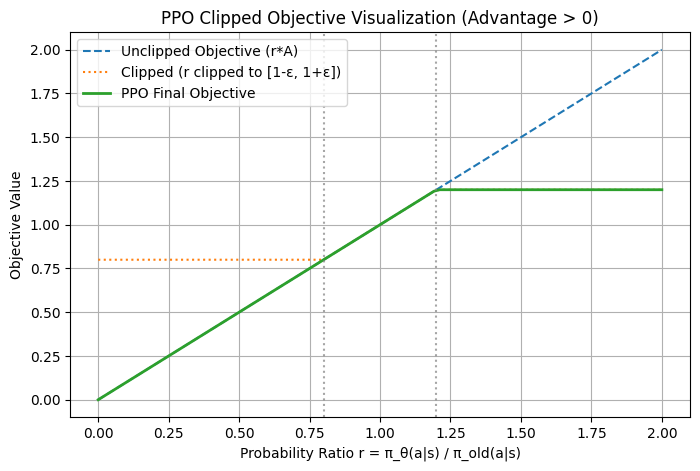

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# 설정
epsilon = 0.2
advantage = 1.0  # 양수인 경우

# r_t: 새로운 정책이 이전보다 얼마나 좋아졌는지 나타내는 비율
r = np.linspace(0, 2, 100)

# unclipped objective: r * A
unclipped = r * advantage

# clipped objective
clipped = np.clip(r, 1 - epsilon, 1 + epsilon) * advantage

# 최종 PPO objective: 둘 중 최소값 선택
ppo_objective = np.minimum(unclipped, clipped)

# 시각화
plt.figure(figsize=(8, 5))
plt.plot(r, unclipped, label='Unclipped Objective (r*A)', linestyle='--')
plt.plot(r, clipped, label='Clipped (r clipped to [1-ε, 1+ε])', linestyle=':')
plt.plot(r, ppo_objective, label='PPO Final Objective', linewidth=2)
plt.axvline(1 - epsilon, color='gray', linestyle=':', alpha=0.7)
plt.axvline(1 + epsilon, color='gray', linestyle=':', alpha=0.7)
plt.title("PPO Clipped Objective Visualization (Advantage > 0)")
plt.xlabel("Probability Ratio r = π_θ(a|s) / π_old(a|s)")
plt.ylabel("Objective Value")
plt.legend()
plt.grid(True)
plt.show()
